# ImageNET tutorial

## Load the pretrained model

We can load a pretrained model from `torchvision`. We will use, for example, 
a ResNet18 model. We can load it in the same way it can be loaded in PyTorch,
then we will pass the model object to the `secml` wrapper. Remember to pass 
the transformations to the `CClassifierPyTorch` object. We could have defined 
the transforms in the `torchvision.transforms.Compose` object, but this would 
now allow us to ensure that the boundary is respected in the input (not transformed) 
space. 

In [1]:
import torch
from torch import nn
from torchvision import models
from secml.data import CDataset
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.features import CNormalizerMeanSTD

model = models.resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = None  # the network is pretrained

# imagenet normalization
normalizer = CNormalizerMeanSTD(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))

# wrap the model, including the normalizer
clf = CClassifierPyTorch(torch_model=model,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=10,
                         batch_size=1,
                         input_shape=(3, 224, 224),
                         softmax_outputs=False,
                         preprocess=normalizer)

Now we can load an image from the web and obtain the classification output. We 
use the PIL and io module for reading the image, requests for getting the image, 
and matplotlib for visualization.

In [42]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),         
])

from PIL import Image
import requests
import io
import matplotlib.pyplot as plt

# img_path = input("Insert image path:")   
img_path = 'https://en.upali.ch/wp-content/uploads/2016/11/arikanischer-ruessel.jpg'
r = requests.get(img_path)
img = Image.open(io.BytesIO(r.content))

# apply transform from torchvision
img_t = transform(img)

# convert to CArray
batch_t = torch.unsqueeze(img_t, 0).view(-1)
batch_c = clf._from_tensor(batch_t)

# fit the normalizer to prevent not fitted error
normalizer.fit(batch_c.atleast_2d(), None)

# prediction for the given image
preds = clf.predict(batch_c)

CArray([0.485 0.485 0.485 ... 0.406 0.406 0.406]) CArray([0.229 0.229 0.229 ... 0.225 0.225 0.225])


Now we have to load the ImageNet human-readable labels from a 
website in order to get the string label with the class name. We can 
display the image along with the predicted label.

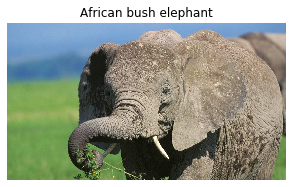

In [11]:
import json
imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r.text))
label = preds.item()
predicted_label = labels[label]

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)
plt.show()

We can create adversarial examples from this image, just as we did in the 
other notebooks. It will take no more than creating a `CAttackEvasionPGDLS` 
object. We should also apply the box constraint with the boundaries 
for the features `lb` and `ub`. Remember that this constraint will project 
the modified sample in the image space `[0, 1]`, ensuring the adversarial 
example remains in the feasible space. The constraints are applied in the 
input space, before the image normalization.

In [4]:
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 5  # Maximum perturbation
lb, ub = 0.0, 1.0 # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 1  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.01, 
    'eta_min': 2.0, 
    'eta_max': None,
    'max_iter': 100, 
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    surrogate_classifier=clf,
                                    surrogate_data=CDataset(batch_c, label),
                                    distance=noise_type, 
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target,
                                    lb=lb, ub=ub)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    batch_c, label, double_init=True)
print("Attack complete!")

adv_label = labels[clf.predict(eva_adv_ds.X).item()]

Attack started...
Attack complete!


Now we can visualize the original (not preprocessed) image and the modified 
one, along with the added perturbation.

Func calls: 864	Grad calls: 70
tensor(0.0106) tensor(1.0000)


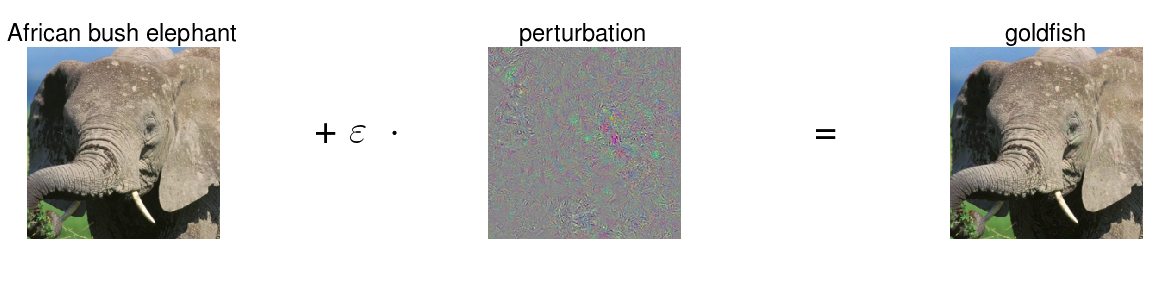

In [41]:
print("Func calls: {}\tGrad calls: {}".format(pgd_ls_attack.f_eval, pgd_ls_attack.grad_eval))

start_img = clf._to_tensor(batch_c).reshape((3, 224, 224))
eva_img = clf._to_tensor(eva_adv_ds.X).reshape((3, 224, 224)).float()


diff_img = start_img - eva_img
diff_img -= diff_img.min()
diff_img /= diff_img.max()

# fix approximation problems - enforce lb and ub again
print(eva_img.min(), eva_img.max())
eva_img[eva_img<lb] = lb
eva_img[eva_img>ub] = ub

from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 20})
plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plt.imshow(start_img.permute(1, 2, 0))
plt.title(predicted_label)
plt.axis('off')
plt.subplot(1, 5, 2)
plt.text(0.3, 0.5, "+\\hspace{4mm}$\\varepsilon$ $\\hspace{4mm}\cdot$", 
         fontsize=40)
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(diff_img.permute(1, 2, 0))
plt.title("perturbation")
plt.axis('off')
plt.subplot(1, 5, 4)
plt.text(0.5, 0.5, "=", fontsize=40)
plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(eva_img.permute(1, 2, 0))
plt.title(adv_label)
plt.axis('off')
plt.show()
